### Time Series Modeling

1. Plot the data with proper labeling and make some observations on the graph.
2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.
3. Use the training set to build a predictive model for the monthly retail sales.
4. Use the model to predict the monthly retail sales on the last year of data.
5. Report the RMSE of the model predictions on the test set.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#loading the data
df = pd.read_csv('us_retail_sales.csv')

In [4]:
#inspecting the dataset
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [5]:
df.tail()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
25,2017,416081,415503,414620,416889,414540,416505,416744.0,417179.0,426501.0,426933.0,431158.0,433282.0
26,2018,432148,434106,433232,435610,439996,438191,440703.0,439278.0,438985.0,444038.0,445242.0,434803.0
27,2019,440751,439996,447167,448709,449552,450927,454012.0,456500.0,452849.0,455486.0,457658.0,458055.0
28,2020,460586,459610,434281,379892,444631,476343,481627.0,483716.0,493327.0,493991.0,488652.0,484782.0
29,2021,520162,504458,559871,562269,548987,550782,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y = df.drop('YEAR', axis=1)
x = df['YEAR']

#### 1. Plot the data with proper labeling and make some observations on the graph.

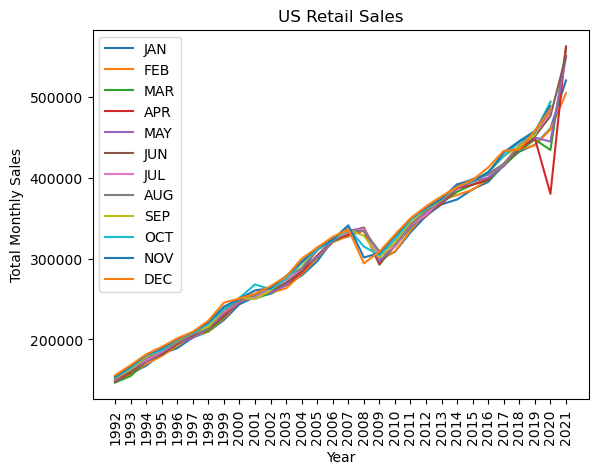

In [7]:
for month in y:
    sns.lineplot(x=x, y=month, data=df,label=month)
      
plt.xlabel('Year')
plt.ylabel('Total Monthly Sales')
plt.title('US Retail Sales')
plt.rcParams['figure.figsize'] = [20, 15]
plt.xticks(x, rotation='vertical')
plt.show()

Observations:
1. If you examine the plot holistically, each month follows an upward trend from 1992 - 2021.
2. There is a dip around 2007-2010 which is explained by the recession period around these times.
3. Following the dip during the recession period, the total sales trends upward again with a slight dip around 2020.
4. Among the months in 2020, March-May experienced the biggest dip in sales which makes sense as it coincides with the start of the Covid-19 lockdown.

#### 2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [8]:
df.columns

Index(['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC'],
      dtype='object')

In [9]:
#unpivoting data
df_unpivot = pd.melt(df, id_vars='YEAR', value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC'], var_name='MONTH', value_name='TOTAL_SALES')

In [10]:
def sort_month(month):
    """Function to get month number"""
    if month == 'JAN':
        return 1
    elif month == 'FEB':
        return 2
    elif month == 'MAR':
        return 3
    elif month == 'APR':
        return 4
    elif month == 'MAY':
        return 5
    elif month == 'JUN':
        return 6
    elif month == 'JUL':
        return 7
    elif month == 'AUG':
        return 8
    elif month == 'SEP':
        return 9
    elif month == 'OCT':
        return 10
    elif month == 'NOV':
        return 11
    elif month == 'DEC':
        return 12

In [11]:
#applying the function to sort data for filtering
df_unpivot['MONTH_NUM'] = df_unpivot['MONTH'].apply(sort_month)

In [12]:
df_unpivot.tail()

,YEAR,MONTH,TOTAL_SALES,MONTH_NUM
355,2017,DEC,433282.0,12
356,2018,DEC,434803.0,12
357,2019,DEC,458055.0,12
358,2020,DEC,484782.0,12
359,2021,DEC,NaN,12


In [13]:
DATE = []
for y, m in zip(df_unpivot['YEAR'], df_unpivot['MONTH_NUM']):
    DATE.append(date(y,m,1))

In [14]:
df_unpivot['DATE'] = DATE

In [15]:
df_unpivot['DATE'] = pd.to_datetime(df_unpivot['DATE'])

In [16]:
df_unpivot['DATE'].head()

0   1992-01-01
1   1993-01-01
2   1994-01-01
3   1995-01-01
4   1996-01-01
Name: DATE, dtype: datetime64[ns]

In [17]:
#sorting the data to filter between test and train set
df_unpivot = df_unpivot.sort_values(by=['DATE'])

In [18]:
df_unpivot.tail(18)

,YEAR,MONTH,TOTAL_SALES,MONTH_NUM,DATE
208,2020,JUL,481627.0,7,2020-07-01
238,2020,AUG,483716.0,8,2020-08-01
268,2020,SEP,493327.0,9,2020-09-01
298,2020,OCT,493991.0,10,2020-10-01
328,2020,NOV,488652.0,11,2020-11-01
358,2020,DEC,484782.0,12,2020-12-01
29,2021,JAN,520162.0,1,2021-01-01
59,2021,FEB,504458.0,2,2021-02-01
89,2021,MAR,559871.0,3,2021-03-01
119,2021,APR,562269.0,4,2021-04-01


In [19]:
#creating a df for the train set
df_train = df_unpivot.drop(df_unpivot.tail(18).index)

In [20]:
#creating the target and feature series
X_train = df_train.drop(['TOTAL_SALES', 'MONTH', 'MONTH_NUM', 'YEAR'], axis=1)
y_train = df_train['TOTAL_SALES']

In [21]:
#creating a df for the test set
df_test = df_unpivot.tail(18)
df_test = df_test.dropna()

In [22]:
#creating the target and feature series
X_test = df_test.drop(['TOTAL_SALES', 'MONTH', 'MONTH_NUM', 'YEAR'], axis=1)
y_test = df_test['TOTAL_SALES']

In [23]:
X_test = X_test.values.astype(float)

#### 3. Use the training set to build a predictive model for the monthly retail sales.

In [24]:
model = LinearRegression()
model.fit(X_train.values, y_train)

LinearRegression()

#### 4. Use the model to predict the monthly retail sales on the last year of data.

In [25]:
y_pred = model.predict(X_test)

In [26]:
pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

,Actual,Predicted
208,481627.0,449450.188174
238,483716.0,450339.376629
268,493327.0,451228.565083
298,493991.0,452089.070039
328,488652.0,452978.258494
358,484782.0,453838.763450
29,520162.0,454727.951904
59,504458.0,455617.140359
89,559871.0,456420.278317
119,562269.0,457309.466772


#### 5. Report the RMSE of the model predictions on the test set.

In [27]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [28]:
print(rmse)

66429.10224837925
